# Analyzing outliers from data & Returning Dates

In [26]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import numpy as np
import os
import time
from itertools import chain
from IPython.display import display_html


##### ETF Data Clean up ###########

class ETFDataCleanup(object):
    
    def __init__(self):
        pass

    def showNaColumns(self,df):
        s=df.isnull().sum()
        print(s[s>0])
    
    def dropNAColumns(self,df):
        return df.dropna(axis='columns')
    
    def computeDailyReturns(self,df):
        return df.pct_change().dropna()        
    
    
####### Get Data for Constituents of ETF

class ConstituentsData(ETFDataCleanup):
    
    def __init__(self,fileName=None,startdate=None,enddate=None):
        self.fileName=fileName
        self.startdate=startdate
        self.enddate=enddate
        self.constituentdata=[]
        self.constituentcloseDF=[]
        self.tickerdf=[]
        self.changeDF=[]
        self.waDF=[]
    
    def getconstituentdata(self):
        self.tickerdf = pd.read_excel(self.fileName)
        tickers=self.tickerdf['Ticker']
        self.tickerdf.set_index('Ticker',inplace=True)
        self.constituentdata =  web.DataReader(tickers,'yahoo',self.startdate,self.enddate)
        self.constituentcloseDF = self.constituentdata['Close'].iloc[:, :]
        
    def stringWeightsToFloat(self):
        self.tickerdf['Weights']=self.tickerdf['Weights'].apply(lambda x: x.replace('%','')).astype(float)
    
    def findNetAssetValue(self):
        self.waDF=self.changeDF.copy()
        for col in self.changeDF.columns:
            # Divide by 100 for weights percentage eg 23.28%
            self.waDF[col]=self.changeDF[col]*self.tickerdf['Weights'].loc[col]/100
        self.waDF['NAV']=self.waDF.sum(axis=1)

####### Get prices of ETF        
class ETFStockPrices(ETFDataCleanup):
    
    def __init__(self,etfticker=None,startdate=None,enddate=None):
        self.etfticker=etfticker
        self.startdate=startdate
        self.enddate=enddate
        self.etfdata=[]
        self.etfchangeDF=[]

        
    def getETFTickerData(self):
        self.etfdata =  web.DataReader(self.etfticker,'yahoo',self.startdate,self.enddate)
 


class ETFArbitrage(object):

    def __init__(self,etfob,waDF):
        self.navDF=pd.merge(etfob,waDF['NAV'],left_index=True,right_index=True)
        self.navDF['Date']=self.navDF.index
        self.navDF['Close']=self.navDF['Close']*100
        self.navDF['NAV']=self.navDF['NAV']*100
        del self.navDF['Date']
        self.navDF['Mispricing']=(self.navDF['Close']-self.navDF['NAV'])
        self.navDF['Z-Score'] = np.abs(stats.zscore(self.navDF['Mispricing']))
    
    def scatterplot(self):
        plt.scatter(self.navDF['Close'],self.navDF['NAV'])
        
    def scatterplot2(self):
        #change figure size for the plot
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0]=12
        fig_size[1]=6
        plt.rcParams["figure.figsize"]=fig_size

        plt.scatter(self.navDF.index,self.navDF['Mispricing'])
    
    def seaborndist(self):
        sns.distplot(self.navDF['Mispricing'].values, hist=True, kde=True, 
             bins='auto', color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
        


# Load any ETF you want

XLK
Tickers with NA Values
Symbols
CTXS     3
NLOK    64
dtype: int64
***************
Check for NA Values again
Series([], dtype: int64)
Symbols         AAPL       ACN      ADBE       ADI       ADP       ADS  \
Date                                                                     
2020-01-16  0.012526  0.008299  0.007115  0.013786  0.011979  0.007510   
2020-01-17  0.011071  0.001053  0.012624  0.002854  0.011379 -0.009822   
2020-01-21 -0.006777 -0.000239  0.000743 -0.001339 -0.003788 -0.009388   
2020-01-22  0.003570  0.001243  0.000171  0.009304  0.012089 -0.002056   
2020-01-23  0.004816  0.006065  0.004856  0.003654 -0.002804  0.001613   
2020-01-24 -0.002882 -0.010015 -0.001109 -0.027222 -0.003486 -0.039356   
2020-01-27 -0.029405 -0.009685 -0.012722 -0.045590 -0.008295 -0.016294   
2020-01-28  0.028289  0.017865  0.022283  0.018715  0.014567  0.015902   
2020-01-29  0.020932 -0.010845 -0.008375 -0.009448 -0.040718  0.021988   
2020-01-30 -0.001449  0.001971  0.014446 -0.00759

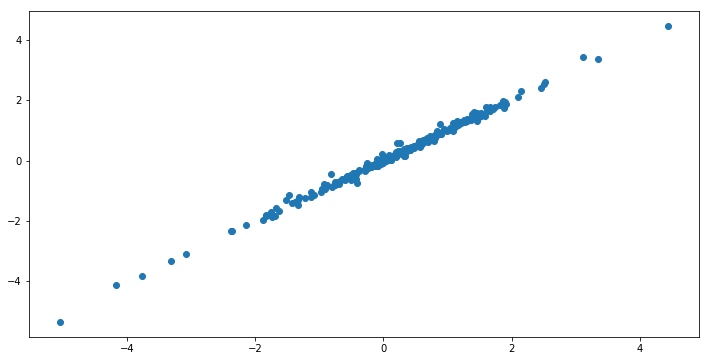

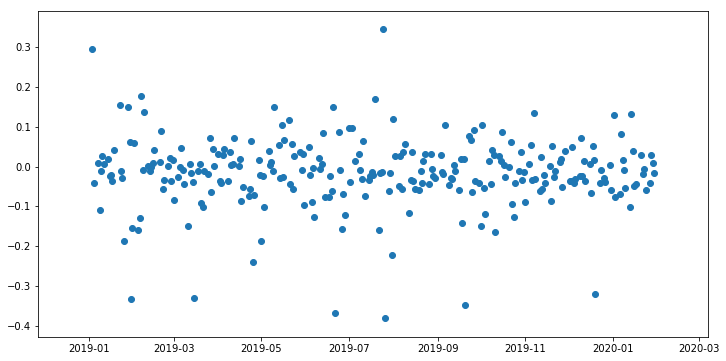

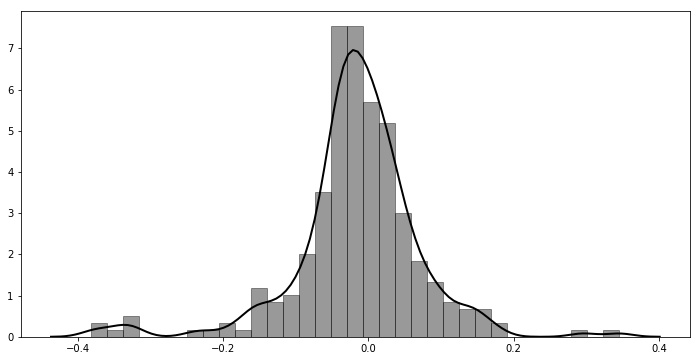

In [27]:
tickeretf="XLK"

filename='ETFDailyData'+'/'+dt.datetime.now().strftime("%Y%m%d")+'/'+tickeretf+'.xls'
startdate=dt.datetime(2019,1,1)
enddate=dt.datetime.today()

ob=ConstituentsData(fileName=filename,startdate=startdate,enddate=enddate)
ob.getconstituentdata()
print(tickeretf)
print("Tickers with NA Values")
ob.showNaColumns(ob.constituentcloseDF)
ob.constituentcloseDF=ob.dropNAColumns(ob.constituentcloseDF)
print("***************")
print("Check for NA Values again")
ob.showNaColumns(ob.constituentcloseDF)
ob.changeDF=ob.computeDailyReturns(ob.constituentcloseDF)
print(ob.changeDF.tail(10))


ob.stringWeightsToFloat()
ob.findNetAssetValue()

print("***************")
print("Data for Constituents")
print(ob.waDF.head(5))

etfob=ETFStockPrices(etfticker=tickeretf,startdate=startdate,enddate=enddate)
etfob.getETFTickerData()
print("Show Any Empty Values")
etfob.showNaColumns(etfob.etfdata)
etfob.etfchangeDF=etfob.computeDailyReturns(etfob.etfdata['Close'])


print("***************")
print("Data for ETF stock prices")
print(etfob.etfchangeDF.head(5))

print("****************")
print("Charts")
arbob=ETFArbitrage(etfob.etfchangeDF,ob.waDF)
arbob.scatterplot()
plt.show()
arbob.scatterplot2()
plt.show()
arbob.seaborndist()
plt.show()



# List down all objects of 3 different classes

In [3]:
print("Constituents Data Objects")
print(dir(ob))

print("*************************")
print("ETF Price Object")
print(dir(etfob))

print("*************************")
print("Arbitrage Data Object")
print(dir(arbob))

Constituents Data Objects
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'changeDF', 'computeDailyReturns', 'constituentcloseDF', 'constituentdata', 'dropNAColumns', 'enddate', 'fileName', 'findNetAssetValue', 'getconstituentdata', 'showNaColumns', 'startdate', 'stringWeightsToFloat', 'tickerdf', 'waDF']
*************************
ETF Price Object
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'compute

## arbob.navDF is the ETF arbitrage dataframe which tells about 
1) Daily Return of ETF<br>
2) NET Asset Value of ETF<br>
3) Mispricing <br>
4) Stocks which moved XLK ETF the most<br>

In [4]:
print(arbob.navDF.head(5))

               Close       NAV  Mispricing
Date                                      
2019-01-03 -5.046761 -5.345812    0.299051
2019-01-04  4.431993  4.476503   -0.044511
2019-01-07  0.894308  0.886728    0.007579
2019-01-08  0.838035  0.948878   -0.110843
2019-01-09  1.294552  1.308103   -0.013551


## Z-Score Method

In [5]:
tempChangeDf=ob.changeDF.copy()*100
tempChangeDf=round(tempChangeDf,4)

In [7]:
negmovers=[]
posmovers=[]

for col in tempChangeDf.T:
    values=(tempChangeDf.T[col].sort_values())
    negmovers.append(dict(values[:3]))
    posmovers.append(dict(values[(len(values)-3):]))

    
arbob.navDF['Top negmovers']=negmovers
arbob.navDF['Top posmovers']=posmovers    

In [8]:
arbob.navDF

,Close,NAV,Mispricing,Z-Score,Top negmovers,Top posmovers
Date,,,,,,
2019-01-03,-5.046761,-5.345812,0.299051,3.564378,"{'SWKS': -10.6533, 'AAPL': -9.9607, 'AMD': -9....","{'LDOS': -1.3833, 'ORCL': -0.973, 'DXC': 0.4037}"
2019-01-04,4.431993,4.476503,-0.044511,0.331085,"{'FTNT': -0.9768, 'CDW': 0.9724, 'AVGO': 0.9828}","{'ADS': 6.7679, 'AMAT': 6.8484, 'AMD': 11.437}"
2019-01-07,0.894308,0.886728,0.007579,0.259534,"{'FLIR': -0.876, 'ADP': -0.541, 'PAYX': -0.5287}","{'FTNT': 4.7526, 'NVDA': 5.2941, 'AMD': 8.2632}"
2019-01-08,0.838035,0.948878,-0.110843,1.083196,"{'AMAT': -4.0525, 'NVDA': -2.4895, 'HPE': -1.919}","{'IPGP': 3.4158, 'CDW': 3.4807, 'VRSN': 3.646}"
2019-01-09,1.294552,1.308103,-0.013551,0.019950,"{'MSI': -2.8031, 'AMD': -2.6988, 'IT': -1.1755}","{'IPGP': 4.5281, 'MU': 5.0385, 'LRCX': 5.1632}"
2019-01-10,0.441778,0.416652,0.025125,0.458480,"{'AMD': -2.2288, 'MSFT': -0.6426, 'ADS': -0.5176}","{'GLW': 2.2574, 'QRVO': 2.3325, 'DXC': 2.4328}"
2019-01-11,-0.188500,-0.194391,0.005891,0.240391,"{'CDW': -1.6476, 'HPQ': -1.3973, 'MSI': -1.327}","{'NVDA': 2.4788, 'AMD': 2.6849, 'QRVO': 2.9583}"
2019-01-14,-0.928549,-0.949036,0.020487,0.405886,"{'WDC': -4.9213, 'QRVO': -3.941, 'MCHP': -3.7469}","{'ADS': 0.4001, 'XRX': 0.7227, 'NVDA': 1.0818}"
2019-01-15,1.509135,1.536709,-0.027573,0.139041,"{'QCOM': -2.74, 'MU': -1.9613, 'STX': -1.1715}","{'ADBE': 3.3254, 'ANET': 3.3723, 'PAYC': 4.9771}"


# Show me days with Arbitrage Opportunities of greater than 3 Standard Deviation

In [41]:
stdthresold=2.3

daysofarbitrage=arbob.navDF[arbob.navDF['Z-Score']>stdthresold]
daysofarbitrage

,Close,NAV,Mispricing,Z-Score
Date,,,,
2019-01-03,-5.046761,-5.342504,0.295743,3.544609
2019-01-30,3.108003,3.441564,-0.333561,3.630469
2019-03-15,0.884588,1.214391,-0.329804,3.587632
2019-04-25,-0.025351,0.214158,-0.239509,2.558130
2019-06-21,-0.823204,-0.454100,-0.369104,4.035721
2019-07-25,-0.410872,-0.756635,0.345763,4.114916
2019-07-26,0.218411,0.599665,-0.381254,4.174246
2019-07-31,-1.512017,-1.290531,-0.221486,2.352638
2019-09-20,-1.473112,-1.124341,-0.348771,3.803888


## Stocks Returns, Volume & Volume Weighted Returns Standard Deviation

In [42]:
# Good Function
class ZscoreAnlysByAttr():

    def __init__(self,data,zthresh,colname):
        self.data=data
        self.data.name=self.data.name+' '+colname
        self.zthresh=zthresh
        
    def getMispricedData(self):
        self.df=self.data.to_frame()
        self.df['Z-Score']=np.abs(stats.zscore(self.df.values.tolist()))
        self.requiredDF=self.df[self.df['Z-Score']>self.zthresh]
        return self.requiredDF

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [43]:
ticker ='AAPL'
weightedMovement=ob.changeDF[ticker]*ob.constituentdata['Volume'][ticker]
weightedMovement=weightedMovement.dropna()

stockVolumeStd=ZscoreAnlysByAttr(ob.constituentdata['Volume'][ticker],stdthresold,'Volume').getMispricedData()
stockReturnStd=ZscoreAnlysByAttr(ob.changeDF[ticker]*100,stdthresold,'Return').getMispricedData()
stockweightedmovement=ZscoreAnlysByAttr(weightedMovement,stdthresold,'Volume Weighted Return').getMispricedData()

In [44]:
display_side_by_side(stockVolumeStd,stockReturnStd,stockweightedmovement)

,AAPL Volume,Z-Score
Date,,
2019-01-03,91312200.0,5.884255
2019-01-04,58607100.0,2.821325
2019-01-07,54777800.0,2.462699
2019-01-30,61109800.0,3.055710
2019-05-01,64827300.0,3.403865
2019-05-13,57430600.0,2.711142
2019-07-31,68892300.0,3.784565
2019-08-01,54017900.0,2.391532
2019-09-20,55413100.0,2.522197


In [45]:
daysofarbitrage

,Close,NAV,Mispricing,Z-Score
Date,,,,
2019-01-03,-5.046761,-5.342504,0.295743,3.544609
2019-01-30,3.108003,3.441564,-0.333561,3.630469
2019-03-15,0.884588,1.214391,-0.329804,3.587632
2019-04-25,-0.025351,0.214158,-0.239509,2.558130
2019-06-21,-0.823204,-0.454100,-0.369104,4.035721
2019-07-25,-0.410872,-0.756635,0.345763,4.114916
2019-07-26,0.218411,0.599665,-0.381254,4.174246
2019-07-31,-1.512017,-1.290531,-0.221486,2.352638
2019-09-20,-1.473112,-1.124341,-0.348771,3.803888


In [46]:
d=[list(daysofarbitrage.index),list(stockVolumeStd.index),list(stockReturnStd.index),list(stockweightedmovement.index)]
#d=[list(stockReturnStd.index),list(daysofarbitrage.index)]
set.intersection(*map(set,d))

{Timestamp('2019-01-03 00:00:00'), Timestamp('2019-01-30 00:00:00')}

### Find Intersection of Dates where values were > 3 std <br>
 1) daysofarbitrage - When ETF Gave 3 STD away Returns<br>
 2) stockVolumeStd - When Volume was 3 std away from normal day for Stock<br>
 3) stockReturnStd - When Daily Returns were 3 srd away from normal days<br>
 4) stockweightedmovement - When Daily Returns * Volume were 3 Stanadrd Deviation Away<br>

### Dates for Mispricing Due to AAPL

### Finding Dates for Mispricing Due to any of all Tickers

In [49]:
tickers=ob.constituentcloseDF.columns
DF=pd.DataFrame()
kvpairs={}
#MispriceDF.set_index('Ticker',inplace=True)
for ticker in tickers:
    weightedMovement=ob.changeDF[ticker]*ob.constituentdata['Volume'][ticker]
    weightedMovement=weightedMovement.dropna()
    stockVolumeStd=ZscoreAnlysByAttr(ob.constituentdata['Volume'][ticker],stdthresold,'Volume').getMispricedData()
    stockReturnStd=ZscoreAnlysByAttr(ob.changeDF[ticker]*100,stdthresold,'Return').getMispricedData()
    stockweightedmovement=ZscoreAnlysByAttr(weightedMovement,stdthresold,'Volume Weighted Return').getMispricedData()
    #d=[list(daysofarbitrage.index),list(stockVolumeStd.index),list(stockReturnStd.index),list(stockweightedmovement.index)]
    d=[list(daysofarbitrage.index),list(stockweightedmovement.index)]
    lst=(list(set.intersection(*map(set,d))))
    kvpairs[ticker]=lst
#kvpairs
MispriceDF=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in kvpairs.items() ]))
print(MispriceDF)

        AAPL        ACN       ADBE        ADI        ADP        ADS  ADSK  \
0 2019-01-30 2019-01-03 2019-03-15 2019-01-03 2019-01-30 2019-04-25   NaN   
1 2019-01-03        NaT        NaT        NaT 2019-01-03        NaT   NaN   
2        NaT        NaT        NaT        NaT        NaT        NaT   NaN   
3        NaT        NaT        NaT        NaT        NaT        NaT   NaN   

        AKAM       AMAT        AMD  ...       SWKS        TEL        TXN  \
0 2019-12-20 2019-03-15 2019-01-30  ... 2019-01-03 2019-01-03 2019-03-15   
1 2019-07-31 2019-01-03 2019-01-03  ...        NaT        NaT 2019-01-03   
2        NaT        NaT 2019-07-31  ...        NaT        NaT        NaT   
3        NaT        NaT        NaT  ...        NaT        NaT        NaT   

           V       VRSN  WDC  WU       XLNX        XRX  ZBRA  
0 2019-01-03 2019-01-03  NaN NaN 2019-04-25 2019-01-30   NaN  
1        NaT        NaT  NaN NaN        NaT        NaT   NaN  
2        NaT        NaT  NaN NaN        NaT 

### Dropping Tickers with all NA values

In [50]:
MispriceDF.dropna(axis='columns',how='all').T

,0,1,2,3
AAPL,2019-01-30,2019-01-03,NaT,NaT
ACN,2019-01-03,NaT,NaT,NaT
ADBE,2019-03-15,NaT,NaT,NaT
ADI,2019-01-03,NaT,NaT,NaT
ADP,2019-01-30,2019-01-03,NaT,NaT
ADS,2019-04-25,NaT,NaT,NaT
AKAM,2019-12-20,2019-07-31,NaT,NaT
AMAT,2019-03-15,2019-01-03,NaT,NaT
AMD,2019-01-30,2019-01-03,2019-07-31,NaT
ANSS,2019-12-20,2019-01-03,NaT,NaT
